# Assignment-3

**Due Date:** 18.12.2022

---------------------------------------

**Instructor:** Erkut Erdem

**TA:** Sibel Kapan

---------------------------------------

**Student:** Emre Çoban

**ID** 2200765028

;**Github Classroom:** https://classroom.github.com/a/Wv6S7qnL



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL.Image as Image
import cv2
import os
import imageio as iio
import tqdm
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from  torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F

## Part I: Theory Questions

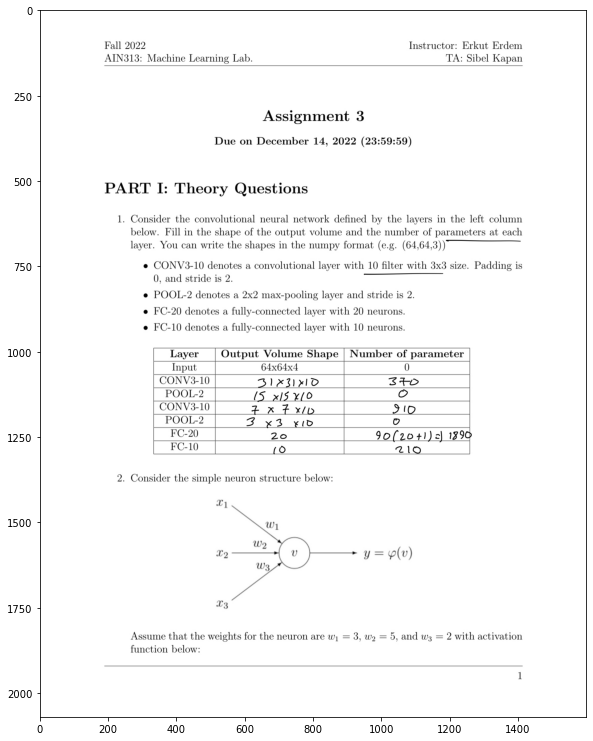

In [3]:
plt.figure(figsize=(16,13))
q1 = cv2.imread("questions/question1.jpg")
plt.imshow(q1)

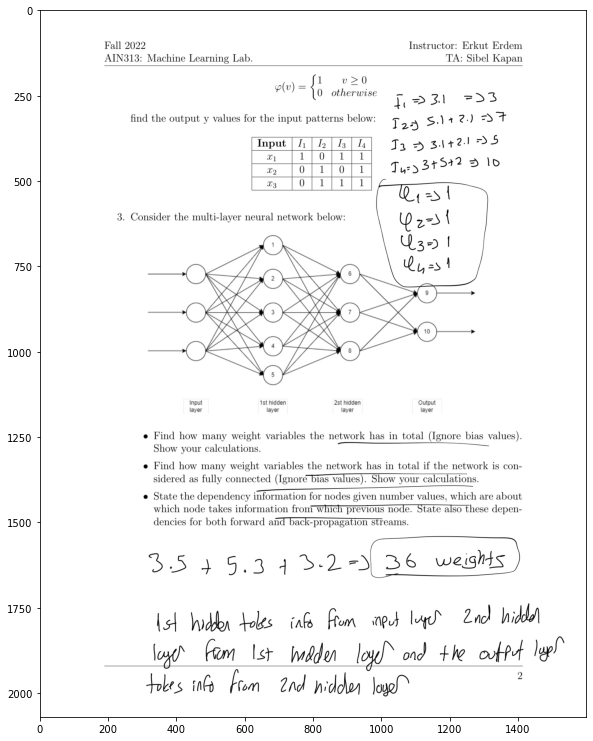

In [4]:
plt.figure(figsize=(16,13))
q2_3 = cv2.imread("questions/question2-3.jpg")
plt.imshow(q2_3)

## Part II: Classification of Flower Species using Neural Network


### Dataset Upload

Dataset uploaded from Drive or local

In [171]:
image_size = 32
batch_size = 64

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),# 32x32
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.25)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.Grayscale(),# about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.25),
    transforms.RandomErasing()      #randomly erasing pixels
])


train_dataset = datasets.ImageFolder("flowers/train", transform=aug_transform)

test_dataset = datasets.ImageFolder("flowers/test", transform=main_transform)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=2)

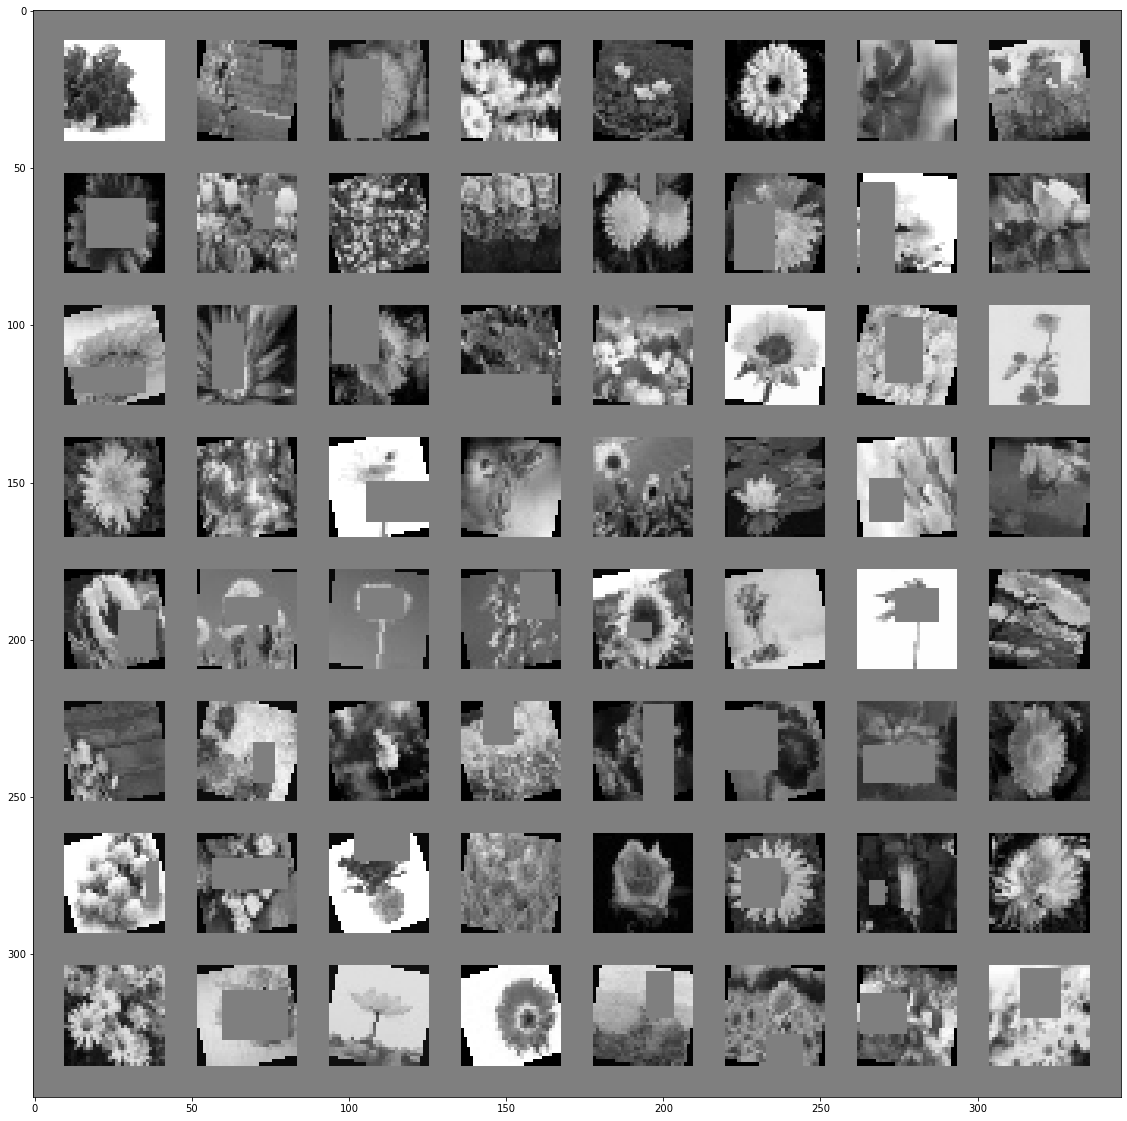

In [172]:
images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
    np_image = np.array(images).transpose((1,2,0))
    unnorm_image = np_image * std + mean
    plt.figure(figsize=(20,20))
    plt.imshow(unnorm_image)

imshow(grid_images, 0.5, 0.25)

# MLP  for classification
### I will use gray images for MLP


In [173]:
device = "cuda" if  torch.cuda.is_available() else "cpu"
device

'cuda'

### Function for initializing model with specified count of hidden layers and activations

In [174]:
def init_mlp(hidden_count,input_dim,hidden_dim,out_dim,act):
    if act=="relu":
         activation = nn.ReLU()
    
    
    elif act=="tanh":
          activation = nn.Tanh()
    
    else :
        print("Only ReLU and Tanh activations are supported")
        
    
    if hidden_count == 1:  ## model with 1 hidden layer
        
        model = nn.Sequential(
        nn.Flatten(),## make 2d image 1d
        nn.Linear(input_dim,hidden_dim),
        activation,
        nn.Linear(hidden_dim,out_dim)
        )
        
        return model
        
    elif hidden_count == 2:  ## model with 2 hidden layer
        
        model = nn.Sequential(
        nn.Flatten(),## make 2d image 1d
        nn.Linear(input_dim,hidden_dim),
        activation,
        nn.Linear(hidden_dim,hidden_dim//2),
        activation,
        nn.Linear(hidden_dim//2,out_dim)
        )
        
        return model
        
        
    else:
        print("Only 1 and 2 hidden layers are supported for MLP")

## Lets try our function whether it works or not

In [175]:
init_mlp(2,1024,128,7,"relu")

## It works well lets move on

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=128, bias=True)
  (2): ReLU()
  (3): Linear(in_features=128, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=7, bias=True)
)

## Now lets create two function one for training the other one for testing
## Some notes about experiments in MLP
### -----------------------------------------------------------------------------------------------------------------
###  I will use SGD Optimizer for each experiment which I found better than ADAM in a few experiment
### For loss I will use cross entropy loss

### I will use these functions for CNN model too except I will create another init_cnn function for initializing CNN Model with specified number of cnn layers etc.

In [176]:
def train_model(model,lr,device,EPOCHS,train_dataloader): 
    
    optimizer = torch.optim.SGD(model.parameters(),lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    
    losses = []
    for epoch in range(EPOCHS):
        LOSS = 0
        CORRECT = 0
        for x, y in train_dataloader:
            optimizer.zero_grad() ## making gradients zero from before loop
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            loss = loss_fn(out,y)
            LOSS += loss.item()
            _,preds = torch.max(out,1)
            CORRECT += (preds == y).sum().item()

            loss.backward() ## calculate gradients
            optimizer.step()  ## optimize weights , biases
        losses.append(LOSS/len(train_dataloader))
        
        print("Epoch {}, Loss {:.4f}, Accuracy: {:.4f}".format(epoch+1,LOSS/len(train_dataloader),CORRECT/(len(train_dataloader)*batch_size)))
    return losses  ## I will return losses so i will plot them
        
        
        
def test_model(model,device,test_dataloader):
    
    loss_fn = nn.CrossEntropyLoss()
    model.to(device)
    model.eval()
    LOSS = 0
    
    with torch.no_grad():
        correct = 0
        total = 0
        for x, y in test_dataloader:
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            loss = loss_fn(out,y)
            LOSS += loss.item()
            _, predictions = torch.max(out.data, 1)
            total += y.size(0)
            correct += (predictions == y).sum().item()
        accuracy = correct / total
        print("Test Loss {:.4f}, Test accuracy: {:.4f}".format(LOSS/len(test_dataloader),accuracy))
      
    LOSS = LOSS/len(test_dataloader)
    return np.round(LOSS,4),np.round(accuracy,4) ## I will return loss and accuracy

##  I will create model with  1 and 2  hidden layer  and test it with 2 different learning rate , 2 different activation functions(relu and tanh) and 2 different batch sizes(32,64),

### I will use 10 epochs
### 2 learning rate are 0.01 and 0.1

## Models with 1 hidden layers and their loss graphs will be saved as jpg

### This code does 8 experiment with same batch sizes in a loop .I will record train losses graph in a folder and record test accuracy and test loss in a dict called test_data which later on i will use for showing results. I will run this code block with one more different batch size too

In [177]:
input_dim = 1024 ## 32 x 32 = 1024
hidden_dim = 128 ## hidden layer dim will be 128 for those with 2 hidden layer second hidden dim is 128//2 => 64
output_dim = 7
EPOCHS = 10

print("BATCH SIZE ",batch_size)
test_data = pd.DataFrame(columns=["MODEL","MODEL-LAYOUT","LOSS_FN","OPTIMIZER","LR","BATCH_SIZE","ACTIVATION_F","TEST_LOSS","TEST_ACCURACY"])

## Loop through all lr,activations and hidden layer counts 

for lr in [0.1,0.01]:
    for act in ["relu","tanh"]:
        for hidden_count in [1,2]:
        
            print(f"LR is {lr}, activation = {act} ,hidden_count = {hidden_count}")
            
            ## create model and train it with specified lr,act,hidden_count
            model = init_mlp(hidden_count,input_dim,hidden_dim,output_dim,act)
            train_losses = train_model(model,lr,device,EPOCHS,train_dataloader)
            test_loss,test_accuracy = test_model(model,device,test_dataloader)
            test_data.loc[len(test_data.index)] = ["MLP",str(hidden_count)+" hidden layer","CROSS_ENTROPY_LOSS","SGD",lr,batch_size,act,test_loss,test_accuracy]
            
            ### plot train losses and save them
            plt.plot(train_losses)
            plt.yticks(np.linspace(1.45,1.9,10)) ## to make them all same in y scale
            plt.savefig("mlp_loss_graphs/batchsize_"+str(batch_size)+"_lr_"+str(lr)+"_"+act+"_"+str(hidden_count)+"_hiddenlayer.png") ## saving train losses
            plt.close() 
            
            print("--------------------------------------------------------")




BATCH SIZE  64
LR is 0.1, activation = relu ,hidden_count = 1
Epoch 1, Loss 1.8083, Accuracy: 0.2690
Epoch 2, Loss 1.7534, Accuracy: 0.2987
Epoch 3, Loss 1.7187, Accuracy: 0.3185
Epoch 4, Loss 1.7065, Accuracy: 0.3262
Epoch 5, Loss 1.6841, Accuracy: 0.3363
Epoch 6, Loss 1.6795, Accuracy: 0.3441
Epoch 7, Loss 1.6752, Accuracy: 0.3442
Epoch 8, Loss 1.6594, Accuracy: 0.3525
Epoch 9, Loss 1.6488, Accuracy: 0.3633
Epoch 10, Loss 1.6376, Accuracy: 0.3678
Test Loss 2.4179, Test accuracy: 0.3029
--------------------------------------------------------
LR is 0.1, activation = relu ,hidden_count = 2
Epoch 1, Loss 1.8199, Accuracy: 0.2627
Epoch 2, Loss 1.7399, Accuracy: 0.2997
Epoch 3, Loss 1.7026, Accuracy: 0.3296
Epoch 4, Loss 1.6769, Accuracy: 0.3252
Epoch 5, Loss 1.6562, Accuracy: 0.3386
Epoch 6, Loss 1.6425, Accuracy: 0.3429
Epoch 7, Loss 1.6107, Accuracy: 0.3598
Epoch 8, Loss 1.6097, Accuracy: 0.3616
Epoch 9, Loss 1.5947, Accuracy: 0.3760
Epoch 10, Loss 1.5790, Accuracy: 0.3767
Test Loss 1.

## RESULTS FOR SPECIFIED BATCH SIZE MLP MODELS
### 8 EXPERIMENT FOR EACH BATCH_SIZE LATER ON I WILL CONCANATE THEM AND SHOW TOGETHER

In [178]:
display(test_data)
test_data.to_csv("mlp_batch_size_"+str(batch_size)+"_results.csv",index=False)

,MODEL,MODEL-LAYOUT,LOSS_FN,OPTIMIZER,LR,BATCH_SIZE,ACTIVATION_F,TEST_LOSS,TEST_ACCURACY
0,MLP,1 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,relu,2.4179,0.3029
1,MLP,2 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,relu,1.7799,0.3221
2,MLP,1 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,tanh,1.8807,0.3036
3,MLP,2 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,tanh,1.7983,0.3043
4,MLP,1 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.01,64,relu,1.7422,0.3164
5,MLP,2 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.01,64,relu,1.7251,0.3379
6,MLP,1 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.01,64,tanh,1.7543,0.3121
7,MLP,2 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.01,64,tanh,1.7541,0.3114


### Lets concat the results we got from batch size = 32 and batch size = 64 for MLP Experiments

In [6]:
## lets see if we can read it well
mlp_32 = pd.read_csv("results/mlp_batch_size_32_results.csv")
mlp_64 = pd.read_csv("results/mlp_batch_size_64_results.csv")
mlp_results = pd.merge(mlp_32,mlp_64,how="outer")
mlp_results

,MODEL,MODEL-LAYOUT,LOSS_FN,OPTIMIZER,LR,BATCH_SIZE,ACTIVATION_F,TEST_LOSS,TEST_ACCURACY
0,MLP,1 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.10,32,relu,2.3149,0.2357
1,MLP,2 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.10,32,relu,1.8111,0.3379
2,MLP,1 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.10,32,tanh,2.0247,0.2321
3,MLP,2 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.10,32,tanh,1.8478,0.2986
4,MLP,1 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.01,32,relu,1.8300,0.2893
5,MLP,2 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.01,32,relu,1.7367,0.3379
6,MLP,1 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.01,32,tanh,1.7619,0.3150
7,MLP,2 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.01,32,tanh,1.7760,0.3279
8,MLP,1 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,relu,2.4179,0.3029
9,MLP,2 hidden layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,relu,1.7799,0.3221


## Lets plot training loss graphs for MLP experiments

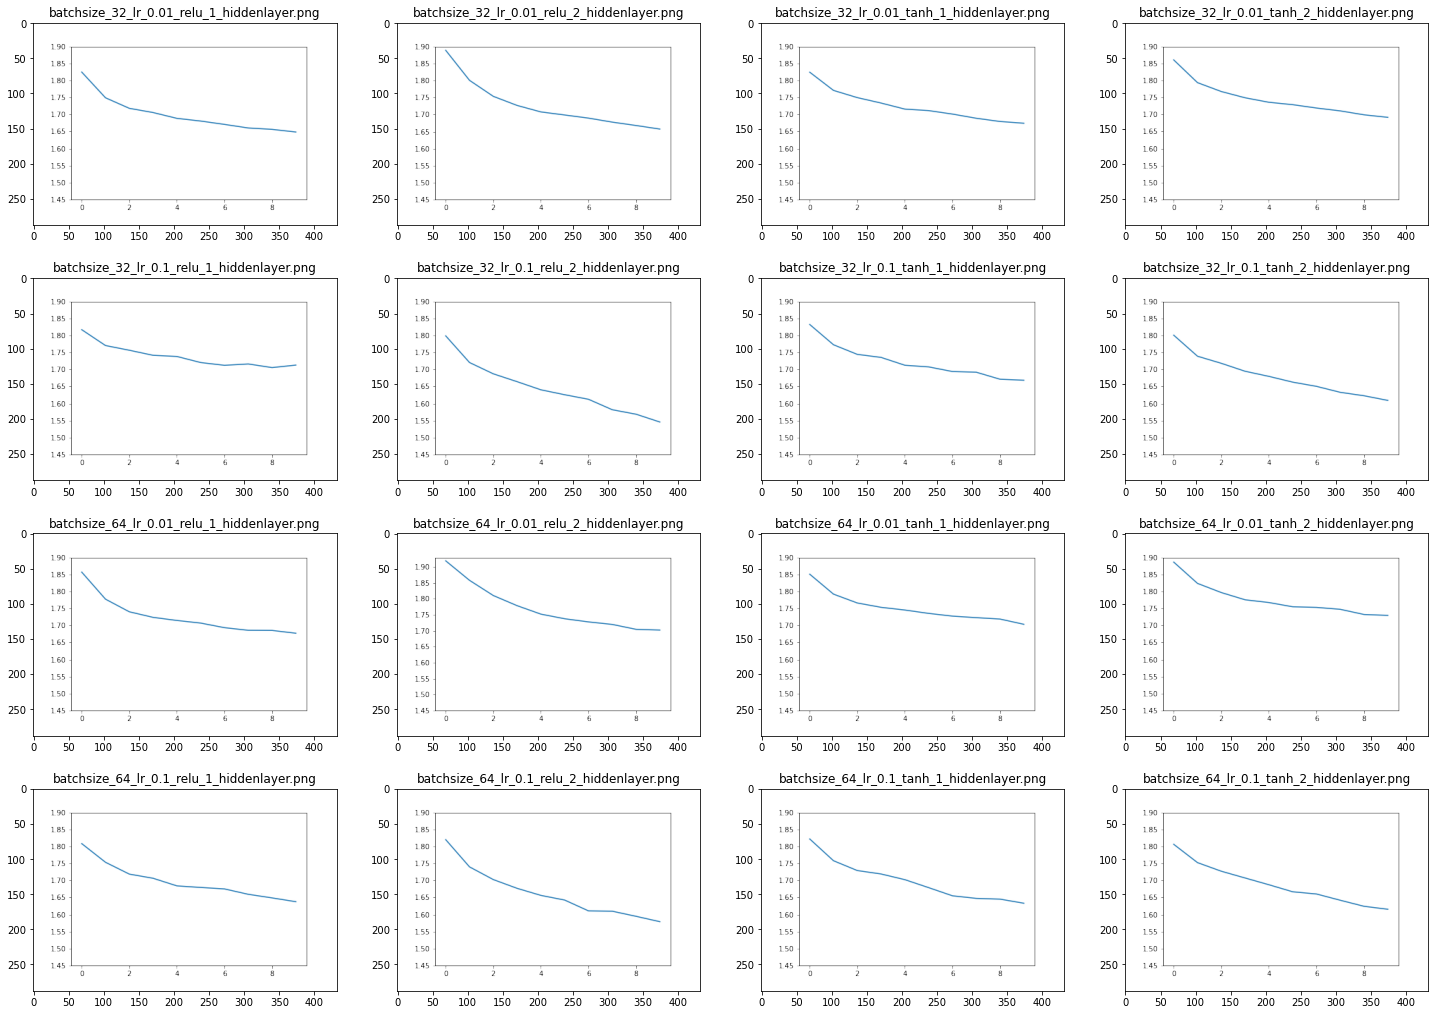

In [7]:
folder = "mlp_loss_graphs/"

graphs =[]
names = []
for img in os.listdir(folder):
    graphs.append(iio.imread(folder+img))
    names.append(img)

    
idx = 0
fig, ax = plt.subplots(4, 4,figsize=(25,18))
for i in range(4):
    for j in range(4):
        ax[i,j].set_title(names[idx])
        ax[i,j].imshow(graphs[idx])
        idx +=1

## Results discussed for batch size = 32

## Test accuracy is lower than last epochs train accuracy which this could be because underfitting. To get more accuracy in both of them We might increase the number of epochs or we can increase the models complexity , increase the image size etc.

## For same 0.1 learning rate and relu activated models we have higher accuracy in model with 2 hidden layer.
## With same learning rate but with tanh activated models we still have higher accuracy in model with 2 hidden layer.
## Model with relu act. has almost %4 accuracy more than tanh model. 
## This could be because of ReLu is the best and most advanced activation function right now compared to the sigmoid and TanH because all the drawbacks like Vanishing Gradient Problem is completely removed in this activation function which makes this activation function more advanced compare to other activation function
## advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time

## For model with 1 hidden layer we get better results when we use lower learning rate this could be because of a large learning rate allows the model to learn faster, at the cost of arriving on a sub-optimal final set of weights. A smaller learning rate may allow the model to learn a more optimal or even globally optimal set of weights

## We get best results when we use relu activation function and 2 hidden layer. In this experiment we get same accuracy for each learning rate but I think this could be by chance so I would preferer smaller learning rate because of the reason I wrote.

## Results Discussed for batch_size = 64
## Using batch size 64 didnt work out well except 1 or 2 experiment had so little higher accuracy but I dont think it worked well for this task.
## Small batches go through the system more quickly and with less variability, which fosters faster learning.
### I found out some researches online and they confirm that using small batch sizes achieves the best generalization performance, for a given computation cost. In all cases, the best results have been obtained with batch sizes of 32 or smaller. Often mini-batch sizes as small as 2 or 4 deliver optimal results

## But in the end our accuracy is at most 32-33 one of the reasons that we cant go more higher is could be because of our MLP models are not enough for this task. We need to use a better model for classifiying images which CNN does that perfectly. 
## Lets move on with CNN model.

### -----------------------------------------------------------------------------------------------------------------------------------------------


## CNN MODEL FOR IMAGE CLASSIFICATION
## I will use RGB images for CNN models.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


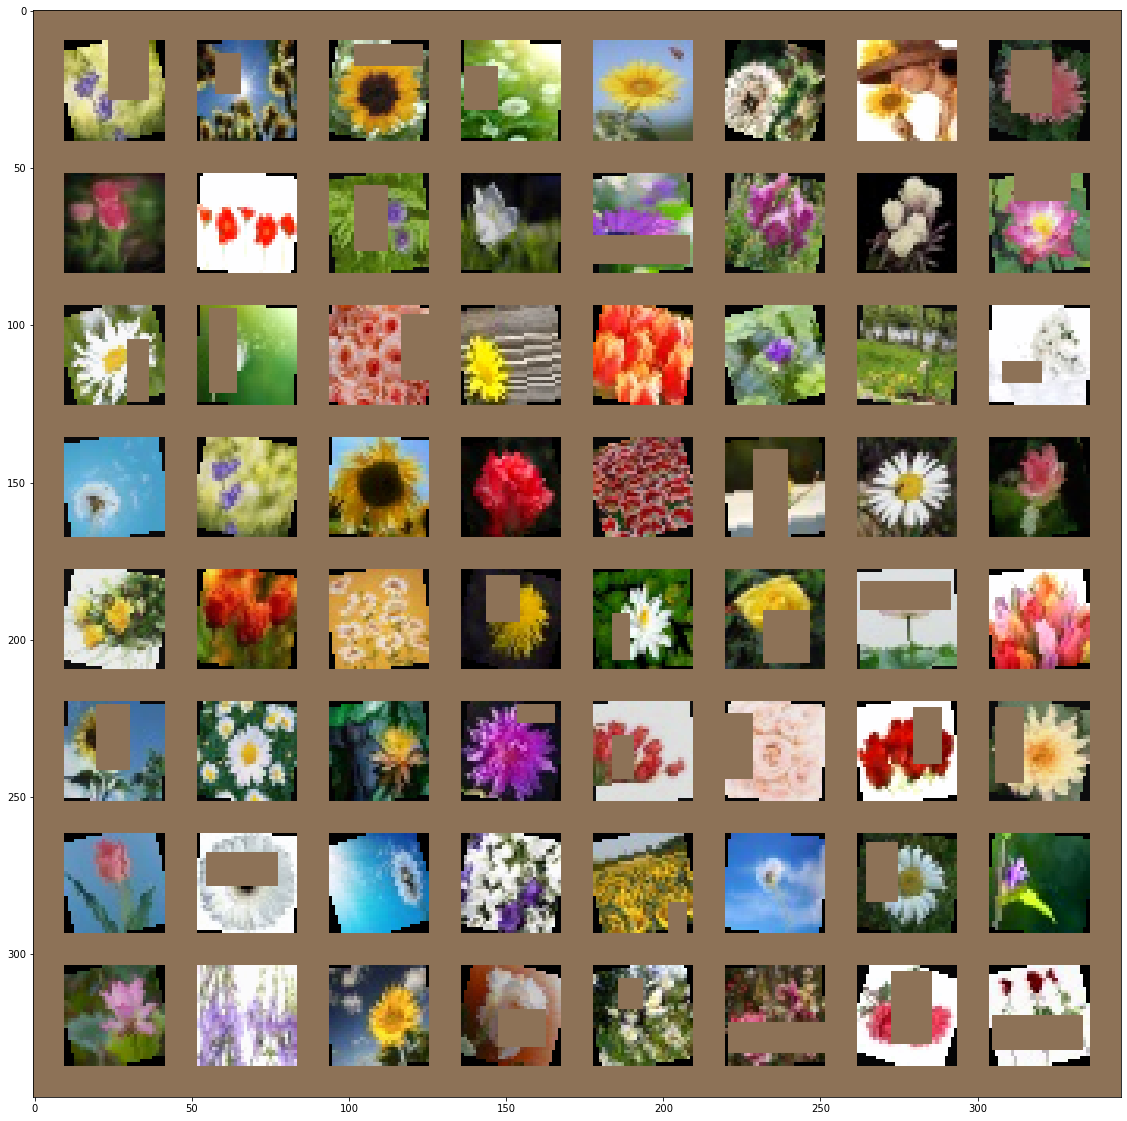

In [180]:
mean = [0.554, 0.450, 0.343]
std = [0.231, 0.241, 0.241]
image_size = 32
batch_size = 64

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),# about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(mean,std),
    transforms.RandomErasing()      #randomly erasing pixels
])


train_dataset = datasets.ImageFolder("flowers/train", transform=aug_transform)

test_dataset = datasets.ImageFolder("flowers/test"
                                    , transform=main_transform)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=2)

images, targets = next(iter(train_dataloader))
grid_images = torchvision.utils.make_grid(images, nrow=8, padding=10)

def imshow(images, mean, std):
    np_image = np.array(images).transpose((1,2,0))
    unnorm_image = np_image * std + mean
    plt.figure(figsize=(20,20))
    plt.imshow(unnorm_image)

imshow(grid_images, mean, std)

##  I plan to use kernel_size =5,padding = 2,stride = 1
### Just like MLP experiments I plan to use SGD Optimizer and Cross Entropy Loss
### I used batch norm 2d after first cnn layer for each model because losses was coming nan we needed to use it

In [181]:
def init_cnn(cnn_count,in_channel,kernel_size,padding,stride,out_dim,act): ## cnn count=>1,2  , in_channel => 3 for rgb 1 for grayscale 
    if act=="relu":
         activation = nn.ReLU()
    
    
    elif act=="tanh":
          activation = nn.Tanh()
    
    else :
        print("Only ReLU and Tanh activations are supported")
        
    
    if cnn_count == 1:  ## model with 1 cnn layer
        
        model = nn.Sequential(
        nn.Conv2d(in_channel,out_channels=16,kernel_size=kernel_size,padding=padding,stride=stride),
        nn.BatchNorm2d(num_features=16), ## BATCH NORM FOR BETTER RESULTS(loss=nan problem)
        nn.MaxPool2d(2),
        activation,
        nn.Flatten(),
        nn.Linear(4096,out_dim)
        )
        
        return model
        
    elif cnn_count == 2:  ## model with 2 cnn layer
        
        model = nn.Sequential(
        nn.Conv2d(in_channel,out_channels=16,kernel_size=kernel_size,padding=padding,stride=stride),
        nn.BatchNorm2d(num_features=16),  ## BATCH NORM FOR BETTER RESULTS(loss=nan problem)
        nn.MaxPool2d(2),
        activation,
        nn.Conv2d(16,out_channels=32,kernel_size=kernel_size,padding=padding,stride=stride),
        nn.MaxPool2d(2),
        activation,
        nn.Flatten(),
        nn.Linear(2048,out_dim)
        )
        
        return model
        
        
    else:
        print("Only 1 and 2 hidden layers are supported for MLP")

### Lets see if our function works

In [182]:
example_model = init_cnn(cnn_count=1,in_channel=3,kernel_size=5,padding=2,stride=1,out_dim=7,act="relu")
example_model

Sequential(
  (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=4096, out_features=7, bias=True)
)

In [183]:
in_channel = 3 ## 3 for rgb
output_dim = 7
EPOCHS = 10

print("BATCH SIZE ",batch_size)
test_data = pd.DataFrame(columns=["MODEL","MODEL-LAYOUT","LOSS_FN","OPTIMIZER","LR","BATCH_SIZE","ACTIVATION_F","TEST_LOSS","TEST_ACCURACY"])

## Loop through all lr,activations and hidden layer counts 

for lr in [0.1,0.01]:
    for act in ["relu","tanh"]:
        for cnn_count in [1,2]:
        
            print(f"LR is {lr}, activation = {act} ,cnn_count = {cnn_count}")
            
            ## create model and train it with specified lr,act,cnn_count
            model = init_cnn(cnn_count=cnn_count,in_channel=in_channel,kernel_size=5,padding=2,stride=1,out_dim=output_dim,act=act)
            train_losses = train_model(model,lr,device,EPOCHS,train_dataloader)
            test_loss,test_accuracy = test_model(model,device,test_dataloader)
            test_data.loc[len(test_data.index)] = ["CNN",str(cnn_count)+" cnn layer","CROSS_ENTROPY_LOSS","SGD",lr,batch_size,act,test_loss,test_accuracy]
            
            ### plot train losses and save them
            plt.plot(train_losses)
            plt.yticks(np.linspace(0.5,1.85,10)) ## to make them all same in y scale
            plt.savefig("cnn_loss_graphs/batchsize_"+str(batch_size)+"_lr_"+str(lr)+"_"+act+"_"+str(cnn_count)+"_cnnlayer.png") ## saving train losses
            plt.close() 
            
            print("--------------------------------------------------------")




BATCH SIZE  64
LR is 0.1, activation = relu ,cnn_count = 1
Epoch 1, Loss 2.0592, Accuracy: 0.3300
Epoch 2, Loss 1.4195, Accuracy: 0.4572
Epoch 3, Loss 1.3465, Accuracy: 0.4874
Epoch 4, Loss 1.2989, Accuracy: 0.5162
Epoch 5, Loss 1.2687, Accuracy: 0.5191
Epoch 6, Loss 1.2394, Accuracy: 0.5441
Epoch 7, Loss 1.2153, Accuracy: 0.5531
Epoch 8, Loss 1.1958, Accuracy: 0.5608
Epoch 9, Loss 1.1723, Accuracy: 0.5722
Epoch 10, Loss 1.1682, Accuracy: 0.5767
Test Loss 1.6646, Test accuracy: 0.4443
--------------------------------------------------------
LR is 0.1, activation = relu ,cnn_count = 2
Epoch 1, Loss 1.5290, Accuracy: 0.4040
Epoch 2, Loss 1.2165, Accuracy: 0.5433
Epoch 3, Loss 1.0898, Accuracy: 0.5962
Epoch 4, Loss 0.9959, Accuracy: 0.6260
Epoch 5, Loss 0.9495, Accuracy: 0.6490
Epoch 6, Loss 0.9065, Accuracy: 0.6615
Epoch 7, Loss 0.8804, Accuracy: 0.6748
Epoch 8, Loss 0.8502, Accuracy: 0.6923
Epoch 9, Loss 0.8345, Accuracy: 0.6901
Epoch 10, Loss 0.7988, Accuracy: 0.7078
Test Loss 1.7962, 

In [184]:
display(test_data)
test_data.to_csv("cnn_batch_size_"+str(batch_size)+"_results.csv",index=False)

,MODEL,MODEL-LAYOUT,LOSS_FN,OPTIMIZER,LR,BATCH_SIZE,ACTIVATION_F,TEST_LOSS,TEST_ACCURACY
0,CNN,1 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,relu,1.6646,0.4443
1,CNN,2 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,relu,1.7962,0.4886
2,CNN,1 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,tanh,1.5291,0.5014
3,CNN,2 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,tanh,1.4914,0.5357
4,CNN,1 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.01,64,relu,1.3076,0.5350
5,CNN,2 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.01,64,relu,1.1369,0.5643
6,CNN,1 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.01,64,tanh,1.4667,0.4729
7,CNN,2 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.01,64,tanh,1.5430,0.4836


In [9]:
## lets see if we can read it well
cnn_32 = pd.read_csv("results/cnn_batch_size_32_results.csv")
cnn_64 = pd.read_csv("results/cnn_batch_size_64_results.csv")
cnn_results = pd.merge(cnn_32,cnn_64,how="outer")
cnn_results

,MODEL,MODEL-LAYOUT,LOSS_FN,OPTIMIZER,LR,BATCH_SIZE,ACTIVATION_F,TEST_LOSS,TEST_ACCURACY
0,CNN,1 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.10,32,relu,1.3749,0.4821
1,CNN,2 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.10,32,relu,1.0318,0.6700
2,CNN,1 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.10,32,tanh,1.5058,0.4443
3,CNN,2 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.10,32,tanh,1.8462,0.4964
4,CNN,1 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.01,32,relu,1.2610,0.5643
5,CNN,2 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.01,32,relu,1.0574,0.6393
6,CNN,1 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.01,32,tanh,1.2160,0.5486
7,CNN,2 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.01,32,tanh,1.2037,0.6000
8,CNN,1 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,relu,1.6646,0.4443
9,CNN,2 cnn layer,CROSS_ENTROPY_LOSS,SGD,0.10,64,relu,1.7962,0.4886


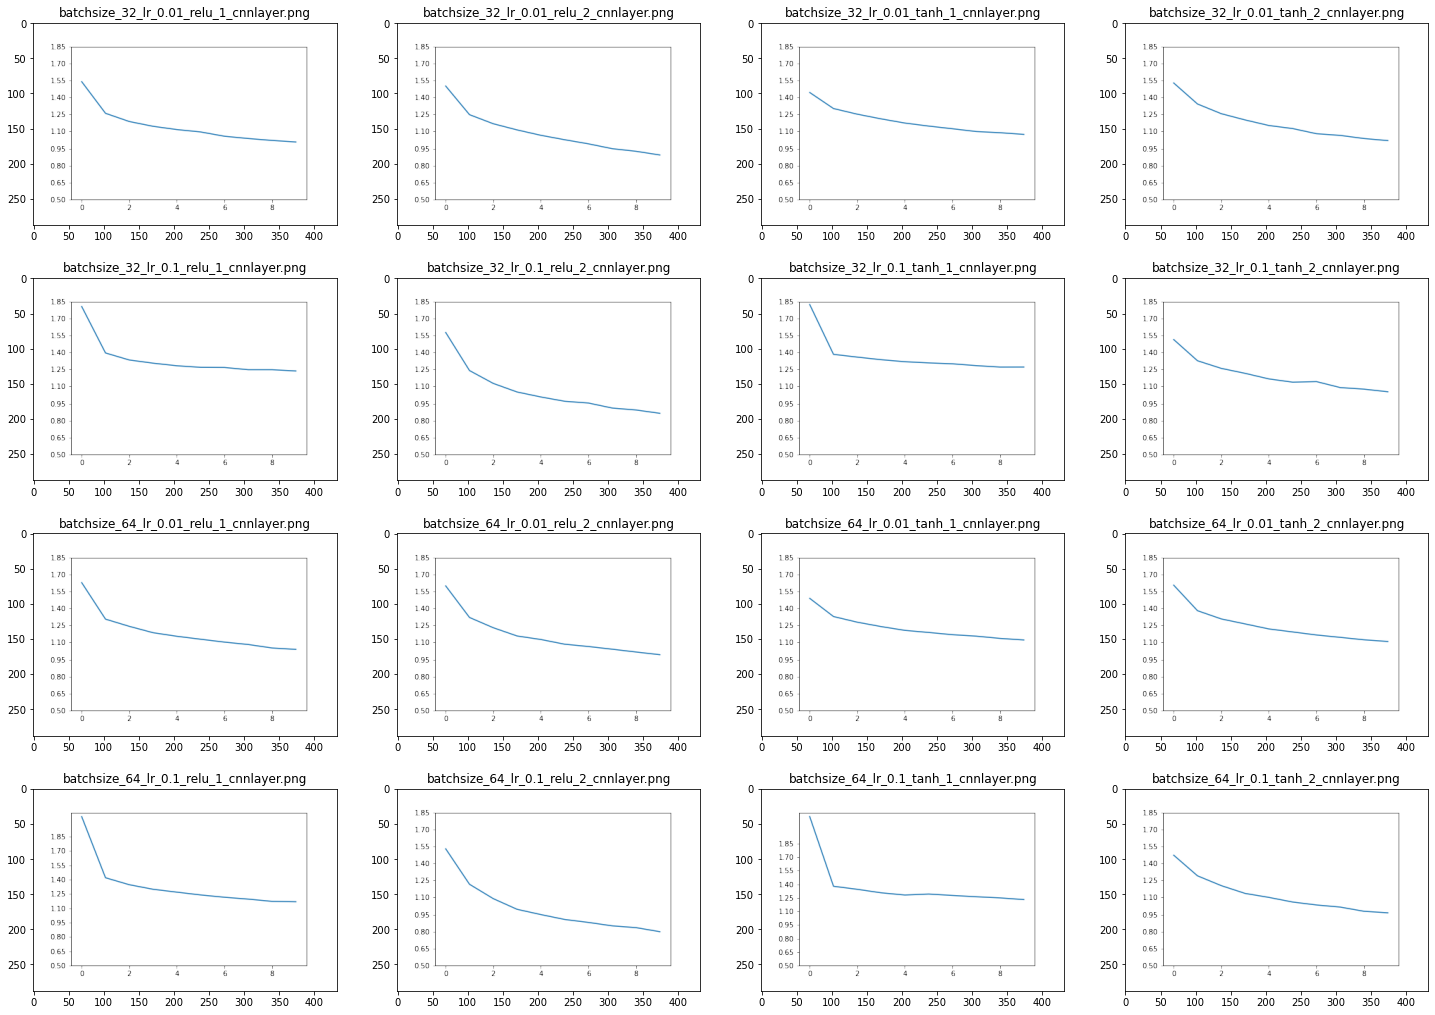

In [10]:
folder = "cnn_loss_graphs/"
idx = 0
graphs =[]
names = []
for img in os.listdir(folder):
    graphs.append(iio.imread(folder+img))
    names.append(img)

    
idx = 0
fig, ax = plt.subplots(4, 4,figsize=(25,18))
for i in range(4):
    for j in range(4):
        ax[i,j].set_title(names[idx])
        ax[i,j].imshow(graphs[idx])
        idx +=1

## We had so much better results using CNN this could be because of simple feedforward neural networks don’t see any order in their inputs. If you shuffled all your images in the same way, the neural network would have the very same performance it had when trained on not shuffled images.
## CNN, in opposition, take advantage of local spatial coherence of images. This means that they are able to reduce dramatically the number of operation needed to process an image by using convolution on patches of adjacent pixels, because adjacent pixels together are meaningful. We also call that local connectivity. Each map is then filled with the result of the convolution of a small patch of pixels, slid with a window over the whole image.

## Results discussed for batch size = 32
### -------------------------------------------------------------


## For same activation and same learning rate we have almost 20 percent accruacy difference between 1cnn layer and 2cnn layer model. This could be because of 2cnn model is more capable of understanding features in images

## For 2 hidden layers and same learning rate relu activation has almost 17 percent more accuracy than using tanh activation. This is because of the reason we talked for MLP too. 

### ""ReLu is the best and most advanced activation function right now compared to the sigmoid and TanH because all the drawbacks like Vanishing Gradient Problem is completely removed in this activation function which makes this activation function more advanced compare to other activation function"""

## For tanh models we had better results when using 0.01 lr compared to using 0.1 lr this is probably because of finding optimal minimum is more easier using smaller learning rates. However when using relu we had better results when lr is larger this is probably because of we have very low epochs I assume that if we had more epochs we would get better results for smaller learning rate since with bigger lr model couldnt find optimum minima always

## Result Discussed for batch size = 64
## For CNN experiments with batch size = 64 we got better results only in 1 experiment compared to batch size = 32. That experiment is 1 cnn layer , tanh and lr = 0.1 model. 

### ------------------------------------------------------------------
## Bonus Part

In [186]:
image_size = 32
batch_size = 64

main_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),# 32x32
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.25)      # normalize
])

aug_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(20),   # rotate images 20 degree randomly
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1,0.1,0.1),
    transforms.Grayscale(),# about saturation brightness vs.
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.25),
    transforms.RandomErasing()      #randomly erasing pixels
])


train_dataset = datasets.ImageFolder("chest_xray/train", transform=aug_transform)

test_dataset = datasets.ImageFolder("chest_xray/test", transform=main_transform)

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=2)

### Example normalized chest img

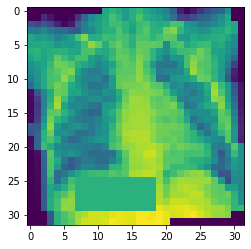

In [187]:
x,y = next(iter(train_dataloader))
plt.imshow(x[10].permute(1,2,0))

In [188]:
device = "cuda" if  torch.cuda.is_available() else "cpu"
EPOCHS = 10
lr = 0.02
device

'cuda'

In [189]:
chest_model = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=3, padding=1),
    nn.MaxPool2d(2),
    nn.Conv2d(6,12,3,1),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(588,128),
    nn.ReLU(),
    nn.Linear(128,3)  ## 3 classes covid,pneumonia,normal
)
chest_model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(chest_model.parameters(),lr=lr)


for epoch in range(EPOCHS):
    LOSS = 0
    CORRECT = 0
    for x, y in train_dataloader:
        optimizer.zero_grad() ## making gradients zero from before loop
        x = x.to(device)
        y = y.to(device)
        out = chest_model(x)
        loss = loss_fn(out,y)
        LOSS += loss
        _,preds = torch.max(out,1)
        CORRECT += (preds == y).sum().item()

        loss.backward() ## calculate gradients
        optimizer.step()  ## optimize weights , biases
    print(f"Epoch {epoch+1}, Loss {LOSS/len(train_dataloader)},  Accuracy {CORRECT/(len(train_dataloader)*batch_size)}")




chest_model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for x, y in test_dataloader:
        x = x.to(device)
        y = y.to(device)
        out = chest_model(x)
        _, predictions = torch.max(out.data, 1)
        total += y.size(0)
        correct += (predictions == y).sum().item()
    accuracy = correct / total
    print("Test accuracy: {:.4f}".format(accuracy))


Epoch 1, Loss 0.726209819316864,  Accuracy 0.7313829787234043
Epoch 2, Loss 0.3899712562561035,  Accuracy 0.8507313829787234
Epoch 3, Loss 0.33905231952667236,  Accuracy 0.870345744680851
Epoch 4, Loss 0.31841686367988586,  Accuracy 0.8746675531914894
Epoch 5, Loss 0.2831282615661621,  Accuracy 0.8916223404255319
Epoch 6, Loss 0.2882266342639923,  Accuracy 0.8939494680851063
Epoch 7, Loss 0.23113694787025452,  Accuracy 0.9102393617021277
Epoch 8, Loss 0.24664407968521118,  Accuracy 0.9069148936170213
Epoch 9, Loss 0.24384404718875885,  Accuracy 0.913563829787234
Epoch 10, Loss 0.25119712948799133,  Accuracy 0.9035904255319149
Test accuracy: 0.8367


### I had 83.67 accuracy in test data and 90 accuracy in train data
### In first assignment when I used knn I had 80. accuracy.
### With more epochs and different learning rates I believe we can achieve more accuracy but to show that cnn is better from knn its enough